## Learning how to Graph and Expose the Graph for Frontend

1) first determine how to graph using python
2) then determine what to expose

**Key learnings**: Python graph is simple and easy but maybe it's better for the server for front end to plot the data

In [4]:
import fastf1
import fastf1.plotting
from matplotlib import pyplot as plt

fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False, color_scheme='fastf1')

# Load session (use cached data when available)
YEAR, EVENT, SESSION_TYPE = 2021, 'Spanish Grand Prix', 'Q'
session = fastf1.get_session(YEAR, EVENT, SESSION_TYPE)
session.load()

core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.1.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '31', '55', '3', '11', '4',

In [5]:
# Pick one lap: by driver + fastest, or by lap number
DRIVER = 'VER'  # e.g. 'VER', 'HAM', 'LEC'
lap = session.laps.pick_driver(DRIVER).pick_fastest()

# Get car telemetry and add distance (meters along the lap)
tel = lap.get_car_data().add_distance()

print(f"Lap: {lap['LapNumber']} | Driver: {DRIVER} | Lap time: {lap['LapTime']}")
print(f"Telemetry points: {len(tel)} | Distance range: {tel['Distance'].min():.0f}m — {tel['Distance'].max():.0f}m")

Lap: 10.0 | Driver: VER | Lap time: 0 days 00:01:16.777000
Telemetry points: 320 | Distance range: 4m — 4676m


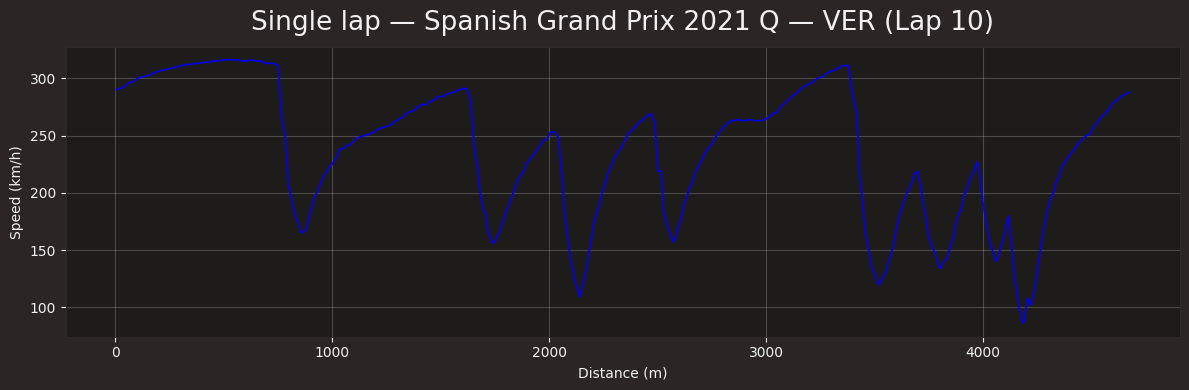

In [6]:
# Single plot: Speed vs Distance ("real time" along the lap)
fig, ax = plt.subplots(figsize=(12, 4))

# Team color: get_driver expects driver number; get it from the lap
driver_num = lap['DriverNumber'] if hasattr(lap, '__getitem__') and 'DriverNumber' in lap.index else None
team_name = session.get_driver(driver_num)['TeamName'] if driver_num is not None else 'Unknown'
ax.plot(tel['Distance'], tel['Speed'], color=fastf1.plotting.team_color(team_name), linewidth=1.2)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Speed (km/h)')
ax.set_title(f'Single lap — {EVENT} {YEAR} {SESSION_TYPE} — {DRIVER} (Lap {int(lap["LapNumber"])})')
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

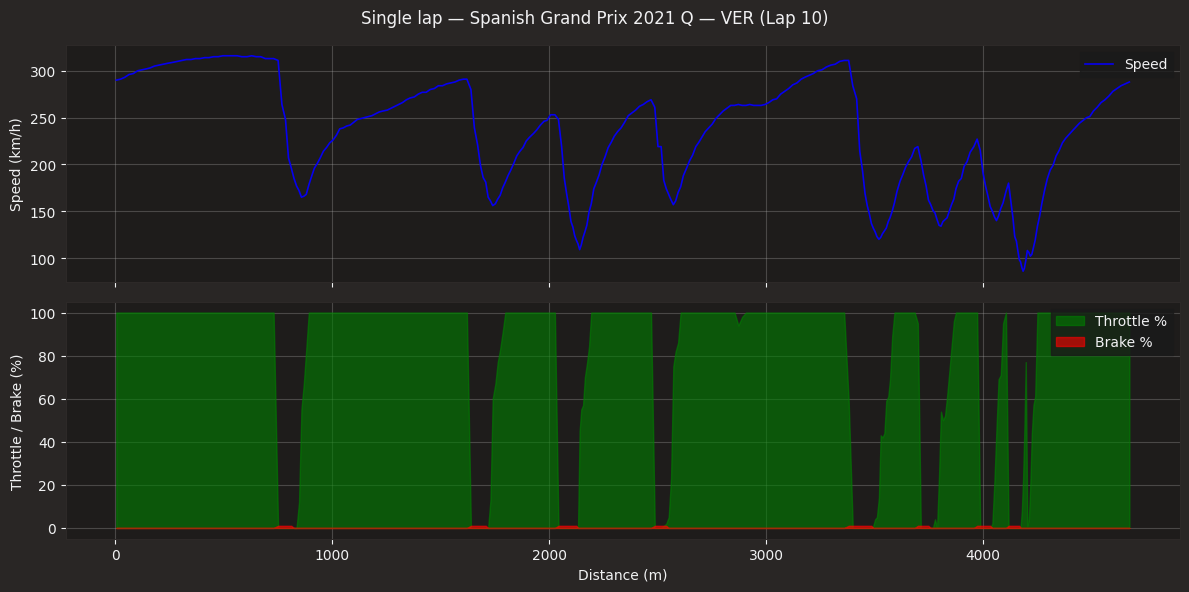

In [7]:
# Optional: Speed + Throttle + Brake (stacked or overlaid)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

driver_num = lap['DriverNumber'] if hasattr(lap, '__getitem__') and 'DriverNumber' in lap.index else None
team_name = session.get_driver(driver_num)['TeamName'] if driver_num is not None else 'Unknown'
team_color = fastf1.plotting.team_color(team_name)
ax1.plot(tel['Distance'], tel['Speed'], color=team_color, label='Speed', linewidth=1.2)
ax1.set_ylabel('Speed (km/h)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

ax2.fill_between(tel['Distance'], 0, tel['Throttle'], alpha=0.6, color='green', label='Throttle %')
ax2.fill_between(tel['Distance'], 0, tel['Brake'], alpha=0.6, color='red', label='Brake %')
ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('Throttle / Brake (%)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

fig.suptitle(f'Single lap — {EVENT} {YEAR} {SESSION_TYPE} — {DRIVER} (Lap {int(lap["LapNumber"])})')
fig.tight_layout()
plt.show()

# Data for backend API

For the backend we can either:
1. Return telemetry as JSON (distance, speed, throttle, brake arrays) and let the frontend plot.
2. Render the plot on the server (matplotlib → PNG/SVG) and return the image URL or base64.

Below we export the telemetry as a dict of lists so we can reuse this structure in the API.

In [8]:
# Export telemetry as lists (backend-friendly shape for JSON)
lap_graph_data = {
    "lap_number": int(lap['LapNumber']),
    "driver": DRIVER,
    "lap_time": str(lap['LapTime']),
    "distance_m": tel['Distance'].tolist(),
    "speed_kmh": tel['Speed'].tolist(),
    "throttle_pct": tel['Throttle'].tolist(),
    "brake_pct": tel['Brake'].tolist(),
}

print("Keys:", list(lap_graph_data.keys()))
print("Number of points:", len(lap_graph_data['distance_m']))

Keys: ['lap_number', 'driver', 'lap_time', 'distance_m', 'speed_kmh', 'throttle_pct', 'brake_pct']
Number of points: 320
